In [1]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
from vincenty import vincenty
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter,DayLocator
from matplotlib.font_manager import FontProperties
import geoplotlib as gp
import scipy as sp
import gdal,ogr
from gdalconst import * 
import datetime
import math
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
tls.set_credentials_file(username='ShawnHou', api_key='OohmqCJaPfb6p6xo4pDF')
from geoplotlib.utils import BoundingBox
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import LeavePLabelOut
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from urllib2 import urlopen, Request
from pprint import pprint
import folium
from IPython.display import HTML, display
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from scipy.spatial import distance
from collections import defaultdict
from operator import itemgetter
from pushover import init, Client
from scipy.spatial import KDTree
from numpy import linalg as LA
from calendar import monthrange
from sklearn import metrics
import tarfile
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from weatherML import *
#for parallel processing
from ipyparallel import Client

import netCDF4
from netCDF4 import Dataset


import skimage as ski
from skimage import filters
from skimage import exposure
from skimage.io import imread, show
from skimage.filters import try_all_threshold
from skimage.viewer import ImageViewer
%matplotlib inline

C:\WorkingGround\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\WorkingGround\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

C:\WorkingGround\Anaconda\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning:

Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.



In [2]:
ill_df=pd.read_csv('data/Illnois_2016_integrated.csv',encoding='utf-8',index_col=0) 
ill_df.head()


,LAT,length_daily,LON,timestamp,txt,URBAN,TMAX,TMIN,PRCP,HUM,CC,WIND,month,length_monthly,length_norm,count,POP
0,41.522237,7,-87.470968,2016-01-01,"[im, at, starbucks, in, schererville, in, http...",True,-1.02,-6.16,0.0,82.75,2.199951,7.363907,1,18.632198,0.375694,1,325.955505
1,41.579548,16,-90.620417,2016-01-01,"[supplemental, health, care, med, surg, /, reg...",True,-3.44,-7.64,0.0,82.75,2.399902,7.588299,1,18.632198,0.858729,1,237.520172
2,41.941025,17,-87.644299,2016-01-01,"[, starting, the, #newyear, off, right, with, ...",True,-1.42,-5.23,0.0,82.75,16.199951,8.465674,1,18.632198,0.912399,1,16993.427734
3,37.072463,6,-88.124378,2016-01-01,"[@kingsparc, @truckerbobs, i, talking, bout, o...",False,2.35,-1.27,0.0,82.25,46.899902,3.844074,1,15.555005,0.385728,1,2.214688
4,38.592709,21,-90.217987,2016-01-01,"[last, year, i, laid, eyes, on, the, most, bea...",True,0.89,-2.56,0.0,75.50,0.399902,6.199333,1,18.632198,1.127081,1,2885.966309


In [3]:
ill_df.dtypes

LAT               float64
length_daily        int64
LON               float64
timestamp          object
txt                object
URBAN                bool
TMAX              float64
TMIN              float64
PRCP              float64
HUM               float64
CC                float64
WIND              float64
month               int64
length_monthly    float64
length_norm       float64
count               int64
POP               float64
dtype: object

In [4]:
YEAR=2016
pixelwidth=0.0416666666667 #PRISM cell size
width_50=pixelwidth*6.25
resol=100
### BOunding box for Illinois
westlon=-91.513053894043
southlat=36.9701309204102
eastlon=-87.0199203491211
northlat=42.5083045959473


n_lat, n_lon=(resol, resol)
lat_bins = np.linspace(southlat, northlat, n_lat)
lon_bins = np.linspace(westlon, eastlon, n_lon)
labels=np.arange(resol-1)
#print lat_bins
#print lon_bins

### Bin all observations
ill_df = ill_df.assign(
    LAT_cut=pd.cut(ill_df.LAT,lat_bins,labels=False),
    LON_cut=pd.cut(ill_df.LON,lon_bins,labels=False)
)

### Categorize on Urban or NOt
ill_urban_df=ill_df[ill_df['URBAN']==True]
ill_rural_df=ill_df[ill_df['URBAN']==False]


print "Spatial Bin on LAT/LON"
ill_df.head()

Spatial Bin on LAT/LON


,LAT,length_daily,LON,timestamp,txt,URBAN,TMAX,TMIN,PRCP,HUM,CC,WIND,month,length_monthly,length_norm,count,POP,LAT_cut,LON_cut
0,41.522237,7,-87.470968,2016-01-01,"[im, at, starbucks, in, schererville, in, http...",True,-1.02,-6.16,0.0,82.75,2.199951,7.363907,1,18.632198,0.375694,1,325.955505,81,89
1,41.579548,16,-90.620417,2016-01-01,"[supplemental, health, care, med, surg, /, reg...",True,-3.44,-7.64,0.0,82.75,2.399902,7.588299,1,18.632198,0.858729,1,237.520172,82,19
2,41.941025,17,-87.644299,2016-01-01,"[, starting, the, #newyear, off, right, with, ...",True,-1.42,-5.23,0.0,82.75,16.199951,8.465674,1,18.632198,0.912399,1,16993.427734,88,85
3,37.072463,6,-88.124378,2016-01-01,"[@kingsparc, @truckerbobs, i, talking, bout, o...",False,2.35,-1.27,0.0,82.25,46.899902,3.844074,1,15.555005,0.385728,1,2.214688,1,74
4,38.592709,21,-90.217987,2016-01-01,"[last, year, i, laid, eyes, on, the, most, bea...",True,0.89,-2.56,0.0,75.50,0.399902,6.199333,1,18.632198,1.127081,1,2885.966309,29,28


In [5]:
ill_urban_grouped_df=ill_urban_df.groupby([ill_urban_df.month,ill_urban_df.LAT_cut,ill_urban_df.LON_cut])['count'].sum().to_frame().reset_index()
ill_rural_grouped_df=ill_rural_df.groupby([ill_rural_df.month,ill_rural_df.LAT_cut,ill_rural_df.LON_cut])['count'].sum().to_frame().reset_index()


ill_urban_grouped_df['monthly_cell_daily_count'] = ill_urban_grouped_df.apply(lambda row: row['count'] / monthrange(YEAR,row.month)[1], axis=1)
ill_rural_grouped_df['monthly_cell_daily_count'] = ill_rural_grouped_df.apply(lambda row: row['count'] / monthrange(YEAR,row.month)[1], axis=1)
ill_rural_grouped_df.head()

,month,LAT_cut,LON_cut,count,monthly_cell_daily_count
0,1,0,61,3,0.096774
1,1,0,62,5,0.161290
2,1,0,63,2,0.064516
3,1,0,64,5,0.161290
4,1,0,69,1,0.032258


In [9]:
ill_df['PRCP'].min()

0.0

### Sune !!!!

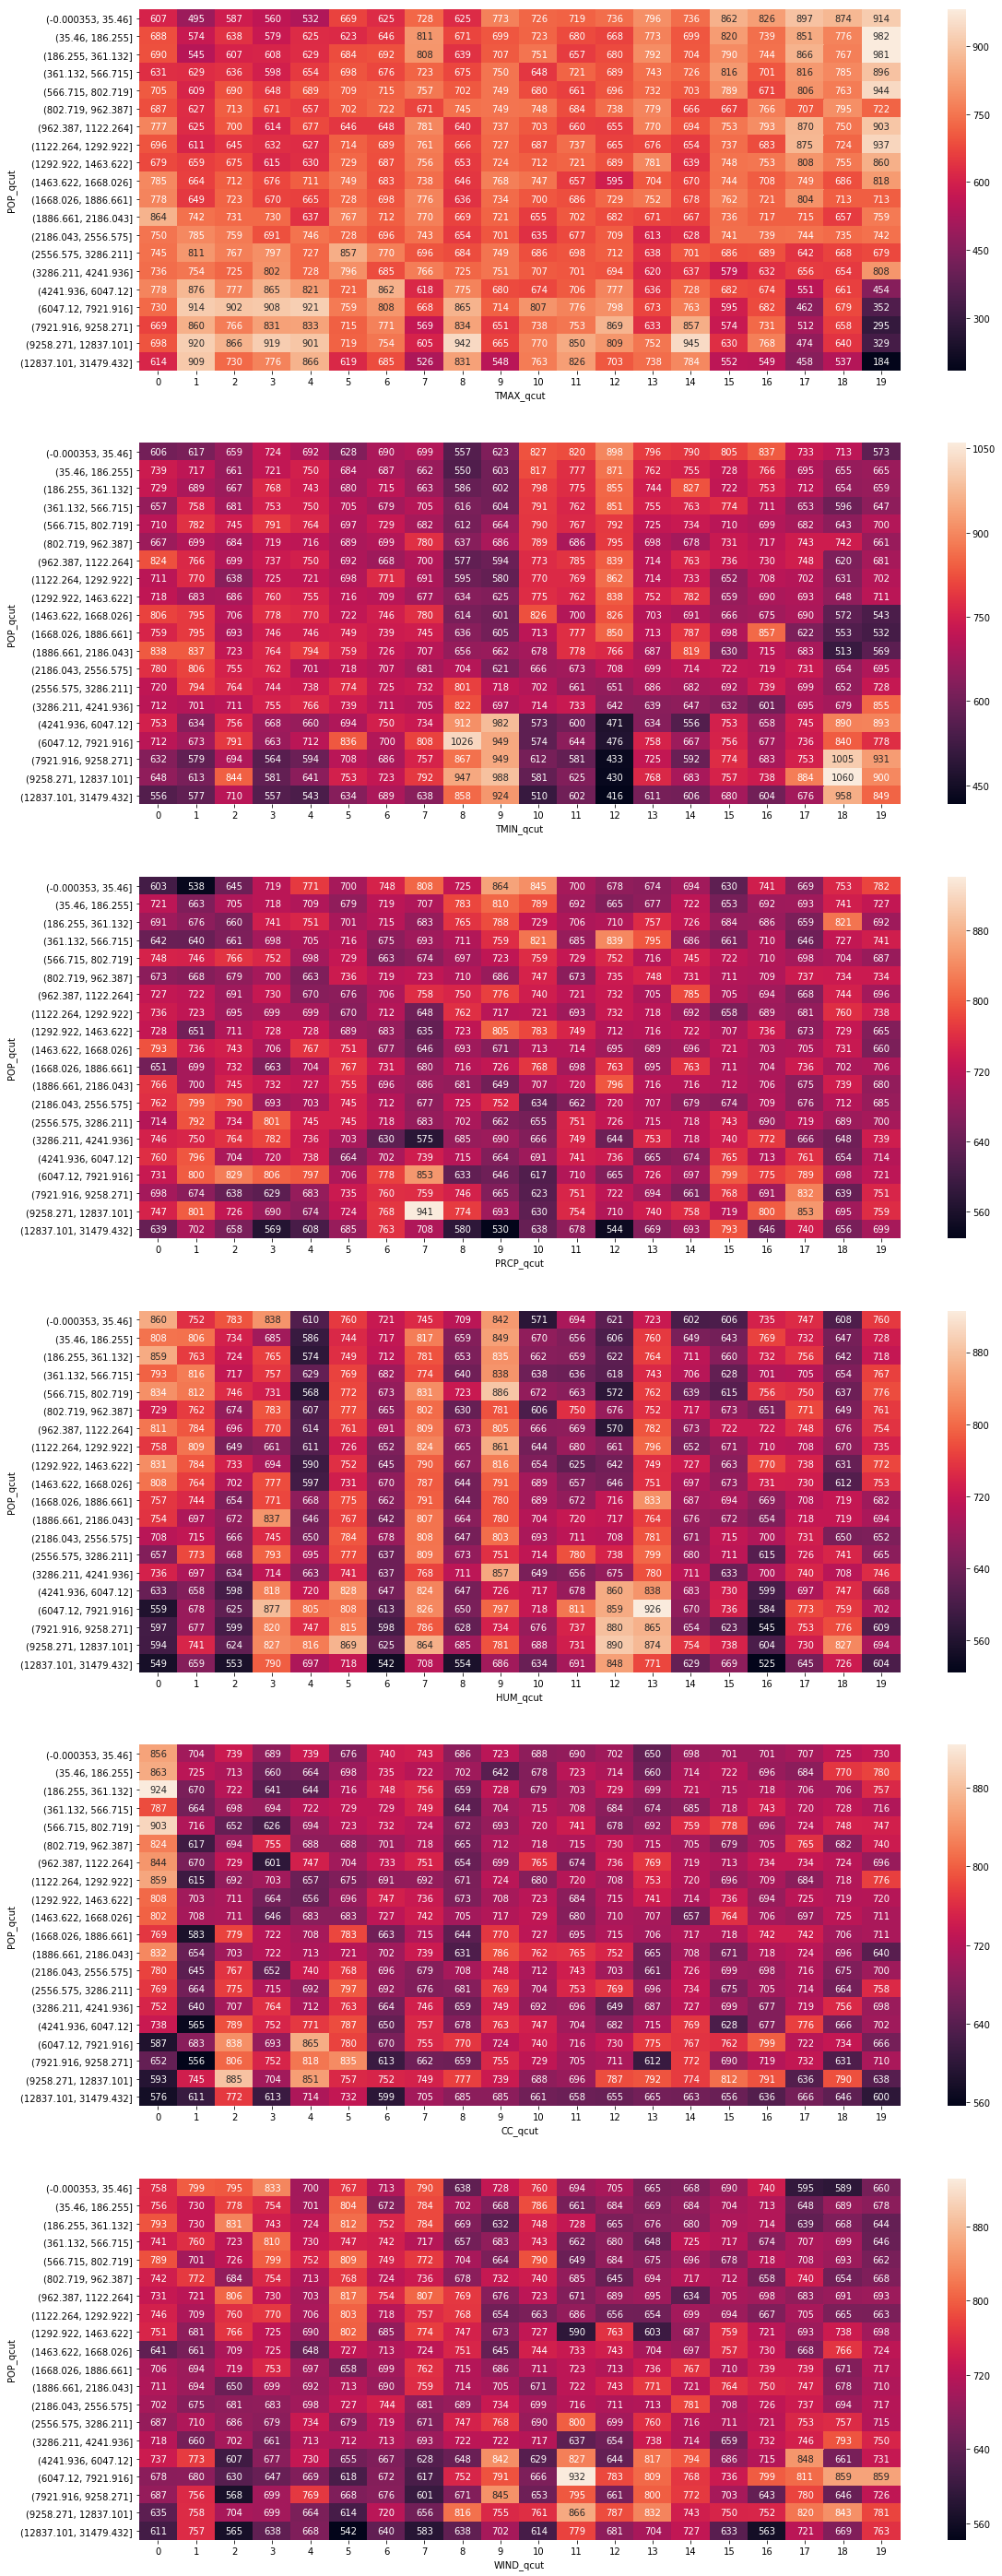

In [70]:
ill_df = ill_df.assign(
    POP_qcut=pd.qcut(ill_df.POP,20),
    TMAX_qcut=pd.qcut(ill_df.TMAX,20,labels=False),
    TMIN_qcut=pd.qcut(ill_df.TMIN,20,labels=False),
    PRCP_qcut=pd.qcut(ill_df.PRCP.rank(method='first').values,20).codes,
    HUM_qcut=pd.qcut(ill_df.HUM,20,labels=False),
    CC_qcut=pd.qcut(ill_df.CC,20,labels=False),
    WIND_qcut=pd.qcut(ill_df.WIND,20,labels=False),
)

pop_tmax_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMAX_qcut])['count'].size().to_frame().reset_index()
pop_tmin_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMIN_qcut])['count'].size().to_frame().reset_index()
pop_prcp_df=ill_df.groupby([ill_df.POP_qcut,ill_df.PRCP_qcut])['count'].size().to_frame().reset_index()
pop_hum_df=ill_df.groupby([ill_df.POP_qcut,ill_df.HUM_qcut])['count'].size().to_frame().reset_index()
pop_cc_df=ill_df.groupby([ill_df.POP_qcut,ill_df.CC_qcut])['count'].size().to_frame().reset_index()
pop_wind_df=ill_df.groupby([ill_df.POP_qcut,ill_df.WIND_qcut])['count'].size().to_frame().reset_index()

pop_tmax_heatmap_df=pop_tmax_df.pivot('POP_qcut','TMAX_qcut','count')
pop_tmin_heatmap_df=pop_tmin_df.pivot('POP_qcut','TMIN_qcut','count')
pop_prcp_heatmap_df=pop_prcp_df.pivot('POP_qcut','PRCP_qcut','count')
pop_hum_heatmap_df=pop_hum_df.pivot('POP_qcut','HUM_qcut','count')
pop_cc_heatmap_df=pop_cc_df.pivot('POP_qcut','CC_qcut','count')
pop_wind_heatmap_df=pop_wind_df.pivot('POP_qcut','WIND_qcut','count')

f, axarr = plt.subplots(6, 1, sharey=True)
f.set_size_inches(18.5, 50.5, forward=True)
ax = sns.heatmap(pop_tmax_heatmap_df,ax=axarr[0],annot=True, fmt="d")
ax = sns.heatmap(pop_tmin_heatmap_df,ax=axarr[1],annot=True, fmt="d")
ax = sns.heatmap(pop_prcp_heatmap_df,ax=axarr[2],annot=True, fmt="d")
ax = sns.heatmap(pop_hum_heatmap_df,ax=axarr[3],annot=True, fmt="d")
ax = sns.heatmap(pop_cc_heatmap_df,ax=axarr[4],annot=True, fmt="d")
ax = sns.heatmap(pop_wind_heatmap_df,ax=axarr[5],annot=True, fmt="d")
#ill_urban_df=ill_df[ill_df['URBAN']==True]
#ill_rural_df=ill_df[ill_df['URBAN']==False]

#ill_urban_grouped_df=ill_urban_df.groupby([ill_urban_df.POP_qcut])['count'].sum().to_frame().reset_index()
#ill_rural_grouped_df=ill_rural_df.groupby([ill_rural_df.POP_qcut])['count'].sum().to_frame().reset_index()

#ill_urban_grouped_df.head()
#axes=ill_df[ill_df['URBAN']==True].plot(kind='hexbin', x='TMAX', y='POP_qcut', gridsize=20,colormap='Reds',sharex=False)

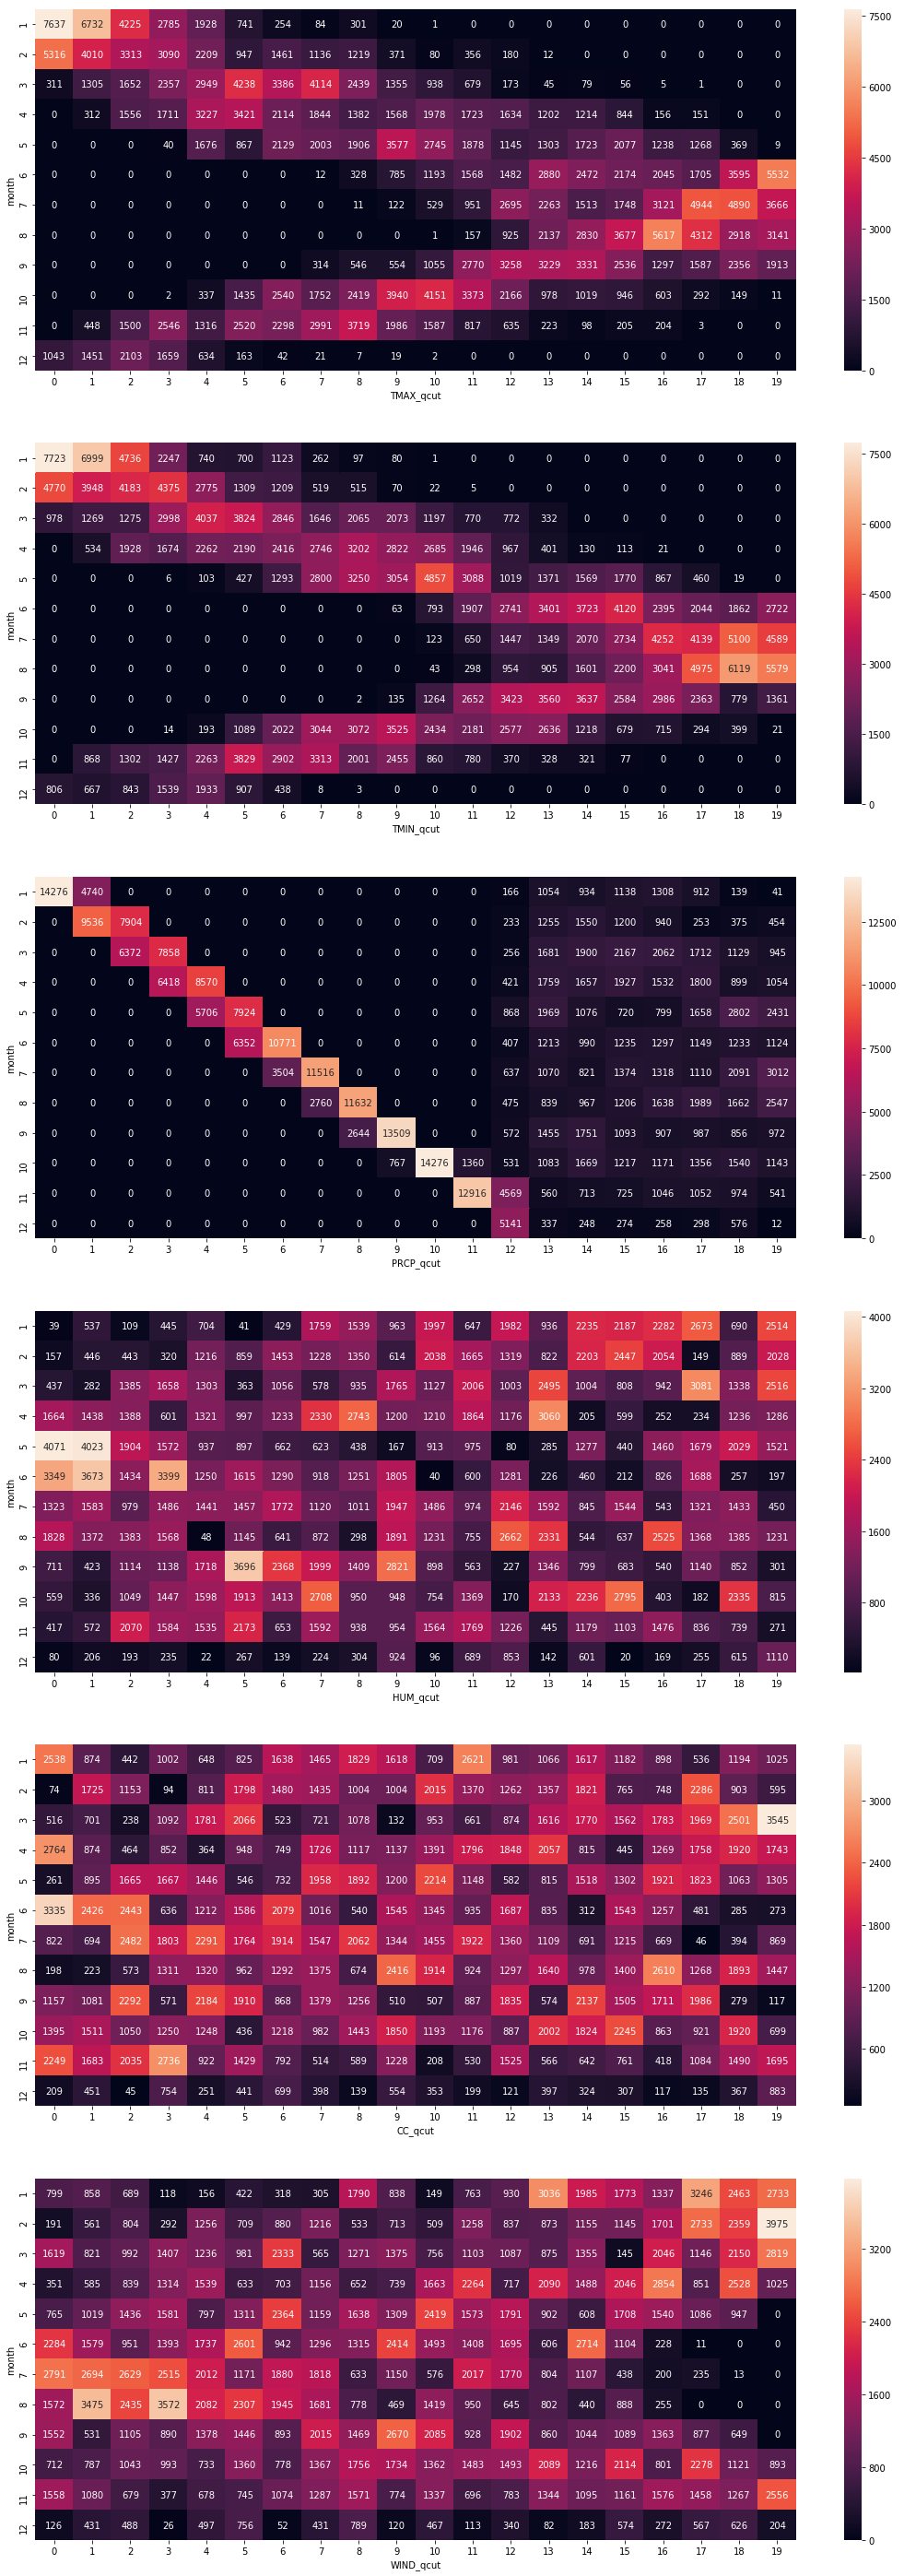

In [74]:
f, axarr = plt.subplots(6, 1, sharey=True)
f.set_size_inches(18.5, 50.5, forward=True)

mon_tmax_df=ill_df.groupby([ill_df.month,ill_df.TMAX_qcut])['count'].size().to_frame().reset_index()
mon_tmin_df=ill_df.groupby([ill_df.month,ill_df.TMIN_qcut])['count'].size().to_frame().reset_index()
mon_prcp_df=ill_df.groupby([ill_df.month,ill_df.PRCP_qcut])['count'].size().to_frame().reset_index()
mon_hum_df=ill_df.groupby([ill_df.month,ill_df.HUM_qcut])['count'].size().to_frame().reset_index()
mon_cc_df=ill_df.groupby([ill_df.month,ill_df.CC_qcut])['count'].size().to_frame().reset_index()
mon_wind_df=ill_df.groupby([ill_df.month,ill_df.WIND_qcut])['count'].size().to_frame().reset_index()

mon_tmax_heatmap_df=mon_tmax_df.pivot('month','TMAX_qcut','count')
mon_tmin_heatmap_df=mon_tmin_df.pivot('month','TMIN_qcut','count')
mon_prcp_heatmap_df=mon_prcp_df.pivot('month','PRCP_qcut','count')
mon_hum_heatmap_df=mon_hum_df.pivot('month','HUM_qcut','count')
mon_cc_heatmap_df=mon_cc_df.pivot('month','CC_qcut','count')
mon_wind_heatmap_df=mon_wind_df.pivot('month','WIND_qcut','count')

mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()] = mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()] = mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_prcp_heatmap_df[mon_prcp_heatmap_df.columns.tolist()] = mon_prcp_heatmap_df[mon_prcp_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_hum_heatmap_df[mon_hum_heatmap_df.columns.tolist()] = mon_hum_heatmap_df[mon_hum_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_cc_heatmap_df[mon_cc_heatmap_df.columns.tolist()] = mon_cc_heatmap_df[mon_cc_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_wind_heatmap_df[mon_wind_heatmap_df.columns.tolist()] = mon_wind_heatmap_df[mon_wind_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")

ax = sns.heatmap(mon_tmax_heatmap_df, annot=True, fmt="d", ax=axarr[0])
ax = sns.heatmap(mon_tmin_heatmap_df, annot=True, fmt="d", ax=axarr[1])
ax = sns.heatmap(mon_prcp_heatmap_df, annot=True, fmt="d", ax=axarr[2])
ax = sns.heatmap(mon_hum_heatmap_df, annot=True, fmt="d", ax=axarr[3])
ax = sns.heatmap(mon_cc_heatmap_df, annot=True, fmt="d", ax=axarr[4])
ax = sns.heatmap(mon_wind_heatmap_df, annot=True, fmt="d", ax=axarr[5])